## 1. Exploration et Analyse des Données (EAD)

• Charger le fichier train.En.csv avec pandas

• Analyser les colonnes disponibles (.info(), .head(), .describe())

• Vérifier la distribution des classes (label)

• Mesurer la longueur des textes (nombre de mots, caractères)

• Visualiser les données :
  - Histogrammes (répartition des classes, longueur des textes)
  - WordCloud (mots fréquents dans les tweets sarcastiques vs non sarcastiques)
  

   Unnamed: 0                                              tweet  sarcastic  \
0           0  The only thing I got from college is a caffein...          1   
1           1  I love it when professors draw a big question ...          1   
2           2  Remember the hundred emails from companies whe...          1   
3           3  Today my pop-pop told me I was not “forced” to...          1   
4           4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1   

                                            rephrase  sarcasm  irony  satire  \
0  College is really difficult, expensive, tiring...      0.0    1.0     0.0   
1  I do not like when professors don’t write out ...      1.0    0.0     0.0   
2  I, at the bare minimum, wish companies actuall...      0.0    1.0     0.0   
3  Today my pop-pop told me I was not "forced" to...      1.0    0.0     0.0   
4  I would say Ted Cruz is an asshole and doesn’t...      1.0    0.0     0.0   

   understatement  overstatement  rhetorical

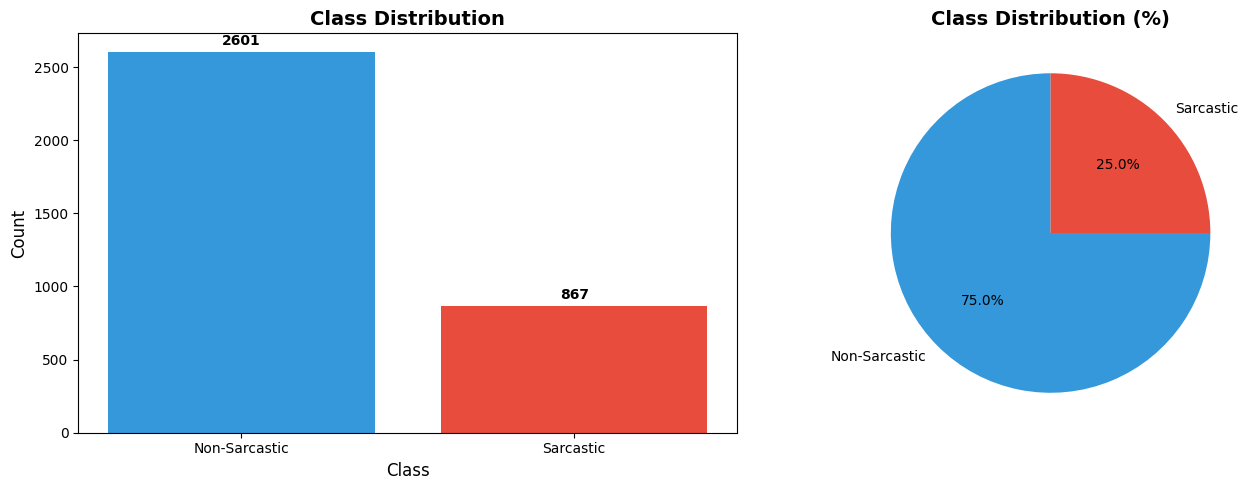

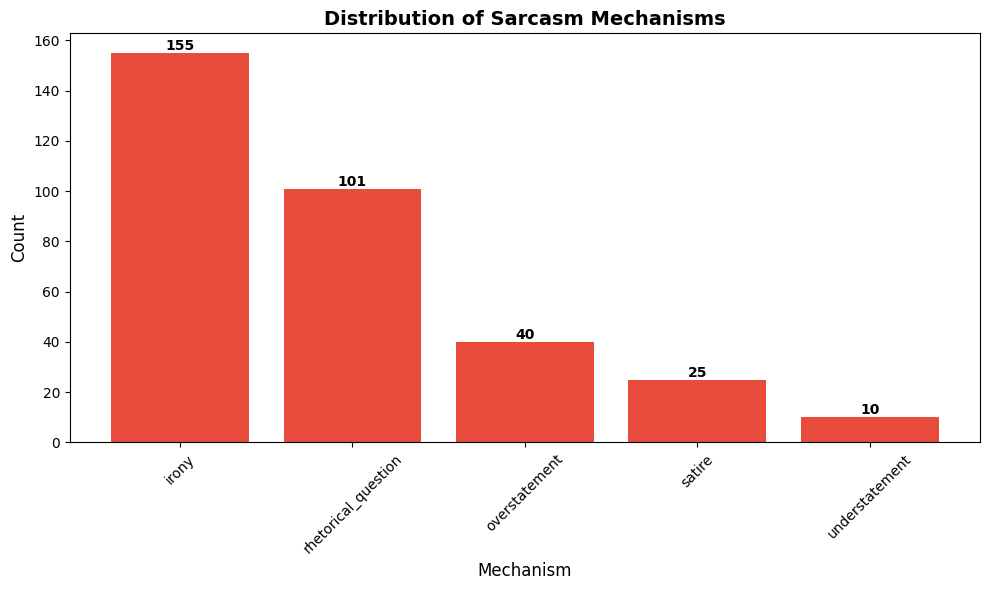

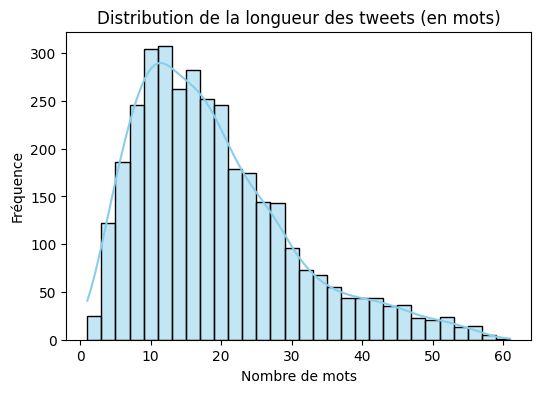

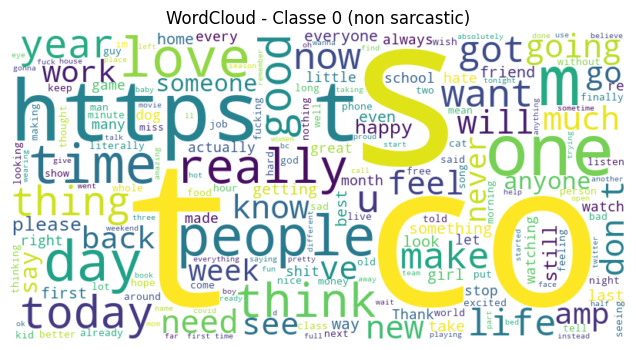

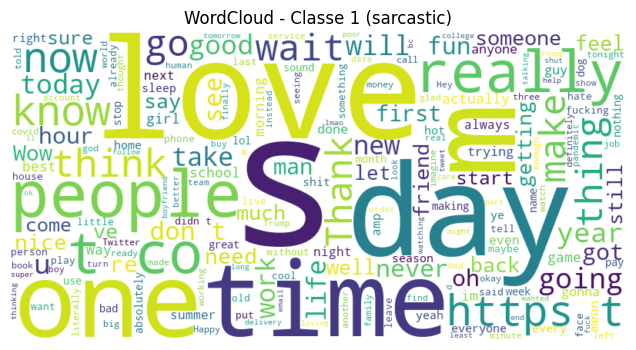

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('train.EN.csv')




# Columns analysis
print(df.head())
print(df.info())
print(df.describe())

# Class distribution
print(df['sarcastic'].value_counts())
print(df[['irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']].sum())

# Text length analysis
df['nb_words'] = df['tweet'].apply(lambda x: len(str(x).strip().split()))
df['nb_chars'] = df['tweet'].apply(lambda x: len(str(x)))
print(df.head())
print(df[['nb_words', 'nb_chars']].describe())

# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = df['sarcastic'].value_counts()
axes[0].bar(['Non-Sarcastic', 'Sarcastic'], class_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['Non-Sarcastic', 'Sarcastic'], 
            autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Sarcasm mechanism distribution
sarcasm_mechanisms = ['irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
mechanism_counts = df[df['sarcastic']==1][sarcasm_mechanisms].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(mechanism_counts.index, mechanism_counts.values, color='#e74c3c')
plt.title('Distribution of Sarcasm Mechanisms', fontsize=14, fontweight='bold')
plt.xlabel('Mechanism', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Text length distribution
dataset = df.copy()
dataset['nb_mots'] = dataset['tweet'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(dataset['nb_mots'], bins=30, kde=True, color='skyblue')
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

# WordCloud visualization
from wordcloud import WordCloud

for label in [0, 1]:
    text = " ".join(dataset[dataset['sarcastic']==label]['tweet'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - Classe {label} ({'sarcastic' if label==1 else 'non sarcastic'})")
    plt.show()

## 2. Prétraitement du Texte

Avant d'entraîner les modèles, il faut nettoyer et transformer les textes :

### Stratégie de prétraitement pour BERT :
• **Prétraitement léger** : BERT gère la casse, la ponctuation et les subwords
• Convertir en minuscules
• Supprimer les URLs, mentions (@user) et nettoyage basique
• **Conserver la ponctuation** car BERT l'utilise pour la compréhension contextuelle

### Colonnes à prétraiter :
• `tweet` : le texte original du tweet (colonne principale)
• `rephrase` : reformulation non-sarcastique du tweet

### Features additionnelles (irony, satire, understatement, overstatement, rhetorical_question) :
• **Pour BERT seul** : ces features ne sont **pas nécessaires** - BERT peut apprendre les patterns du sarcasme directement
• **Pour amélioration** : elles peuvent être ajoutées comme features supplémentaires pour un modèle hybride
• **Décision** : nous les conserverons pour permettre des expérimentations futures

In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Télécharger les ressources NLTK nécessaires
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    pass

# Initialiser les outils de prétraitement
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_for_bert(text):
    """
    Prétraitement adapté pour BERT:
    - BERT gère la casse, la ponctuation et les subwords
    - On se concentre sur le nettoyage de base
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Supprimer les mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # Supprimer les hashtags mais garder le texte (ex: #Brexit -> brexit)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Supprimer les caractères HTML
    text = re.sub(r'&\w+;', '', text)
    
    # Supprimer les caractères spéciaux excessifs mais garder la ponctuation de base
    # BERT utilise la ponctuation pour la compréhension contextuelle
    text = re.sub(r'[^\w\s.,!?;:\'-]', ' ', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Créer les colonnes nettoyées
print("="*80)
print("PRÉTRAITEMENT DES TEXTES POUR BERT")
print("="*80)
print(f"\nNombre de tweets avant prétraitement: {len(df)}")

# Prétraiter la colonne 'tweet' (principale)
df['text_clean_bert'] = df['tweet'].apply(preprocess_text_for_bert)

# Prétraiter la colonne 'rephrase' (reformulation non-sarcastique)
df['rephrase_clean_bert'] = df['rephrase'].apply(preprocess_text_for_bert)

# Supprimer les lignes avec des textes vides après nettoyage
df_clean = df[(df['text_clean_bert'].str.len() > 0)].copy()

print(f"Nombre de tweets après prétraitement: {len(df_clean)}")
print(f"Tweets supprimés (texte vide): {len(df) - len(df_clean)}")



PRÉTRAITEMENT DES TEXTES POUR BERT

Nombre de tweets avant prétraitement: 3468
Nombre de tweets après prétraitement: 3462
Tweets supprimés (texte vide): 6


## 3. Vectorisation avec RoBERTa

RoBERTa (Robustly Optimized BERT Pretraining Approach) est une version améliorée de BERT qui offre de meilleures performances pour la compréhension du contexte et du sarcasme.

### Stratégie :
• Utiliser `roberta-base` pré-entraîné
• Extraire les embeddings de la dernière couche cachée
• Appliquer mean pooling pour obtenir une représentation fixe du texte
• Gérer le déséquilibre des classes avec SMOTE (oversampling) et RandomUnderSampler (undersampling)

In [4]:
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np
from tqdm import tqdm

# Vérifier la disponibilité de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

# Charger le modèle RoBERTa et le tokenizer
print("\nChargement du modèle RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.to(device)
roberta_model.eval()

print("✓ Modèle RoBERTa chargé avec succès")

C:\Users\SP\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device utilisé: cpu

Chargement du modèle RoBERTa...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Modèle RoBERTa chargé avec succès


In [5]:
def get_roberta_embeddings(texts, batch_size=16):
    embeddings = []
    
    # Traiter les textes par batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Extraction des embeddings"):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenizer les textes
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        
        # Déplacer vers le device (GPU si disponible)
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        # Extraire les embeddings sans calculer les gradients
        with torch.no_grad():
            outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            # Utiliser la dernière couche cachée
            last_hidden_state = outputs.last_hidden_state
            
            # Mean pooling: moyenne des tokens (en ignorant le padding)
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Extraire les embeddings pour les textes nettoyés
print("\n" + "="*80)
print("EXTRACTION DES EMBEDDINGS ROBERTA")
print("="*80)

X_roberta = get_roberta_embeddings(df_clean['text_clean_bert'].tolist())
y = df_clean['sarcastic'].values

print(f"\nShape des embeddings: {X_roberta.shape}")
print(f"Shape des labels: {y.shape}")
print(f"\nDistribution des classes:")
print(f"  Non-sarcastic (0): {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.2f}%)")
print(f"  Sarcastic (1): {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.2f}%)")


EXTRACTION DES EMBEDDINGS ROBERTA


Extraction des embeddings: 100%|██████████| 217/217 [01:36<00:00,  2.25it/s]


Shape des embeddings: (3462, 768)
Shape des labels: (3462,)

Distribution des classes:
  Non-sarcastic (0): 2595 (74.96%)
  Sarcastic (1): 867 (25.04%)


In [6]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_roberta, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*80)
print("DIVISION TRAIN/TEST")
print("="*80)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"  Non-sarcastic: {(y_train == 0).sum()}")
print(f"  Sarcastic: {(y_train == 1).sum()}")
print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Non-sarcastic: {(y_test == 0).sum()}")
print(f"  Sarcastic: {(y_test == 1).sum()}")


DIVISION TRAIN/TEST

Train set: 2769 samples
  Non-sarcastic: 2076
  Sarcastic: 693

Test set: 693 samples
  Non-sarcastic: 519
  Sarcastic: 174


## 5. Équilibrage des données avec SMOTE et Entraînement des Modèles

Dans cette section, nous allons :
- Appliquer SMOTE pour équilibrer les classes
- Entraîner 5 modèles de classification différents
- Évaluer leurs performances

In [7]:
# Appliquer SMOTE pour équilibrer les classes
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, confusion_matrix
)
import time

print("\n" + "="*80)
print("ÉQUILIBRAGE DES DONNÉES AVEC SMOTE")
print("="*80)

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAvant SMOTE:")
print(f"  Total: {len(y_train)} samples")
print(f"  Non-sarcastic (0): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.2f}%)")
print(f"  Sarcastic (1): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.2f}%)")

print(f"\nAprès SMOTE:")
print(f"  Total: {len(y_train_smote)} samples")
print(f"  Non-sarcastic (0): {(y_train_smote == 0).sum()} ({(y_train_smote == 0).sum() / len(y_train_smote) * 100:.2f}%)")
print(f"  Sarcastic (1): {(y_train_smote == 1).sum()} ({(y_train_smote == 1).sum() / len(y_train_smote) * 100:.2f}%)")

# Sauvegarder les données SMOTE
np.save('X_train_smote.npy', X_train_smote)
np.save('y_train_smote.npy', y_train_smote)
print("\n✓ Données SMOTE sauvegardées")


ÉQUILIBRAGE DES DONNÉES AVEC SMOTE

Avant SMOTE:
  Total: 2769 samples
  Non-sarcastic (0): 2076 (74.97%)
  Sarcastic (1): 693 (25.03%)

Après SMOTE:
  Total: 4152 samples
  Non-sarcastic (0): 2076 (50.00%)
  Sarcastic (1): 2076 (50.00%)

✓ Données SMOTE sauvegardées



ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

Nombre de modèles à entraîner: 5
 * Logistic Regression
 * SVM
 * Random Forest
 * Naive Bayes
 * KNN

Entraînement du modèle: Logistic Regression

Résultats pour Logistic Regression:
  Accuracy:  0.6883
  Precision: 0.4071
  Recall:    0.5287
  F1-Score:  0.4600
  AUC:       0.6895
  Temps d'entraînement: 2.06 secondes


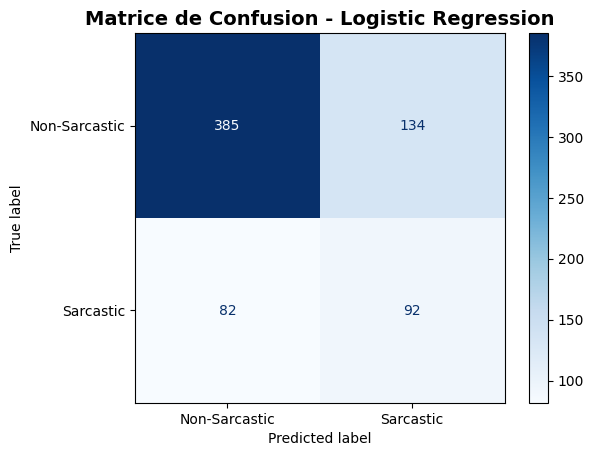


Matrice de confusion:
  [[TN: 385, FP: 134]
   [FN: 82, TP: 92]]

Rapport de classification:
               precision    recall  f1-score   support

Non-Sarcastic       0.82      0.74      0.78       519
    Sarcastic       0.41      0.53      0.46       174

     accuracy                           0.69       693
    macro avg       0.62      0.64      0.62       693
 weighted avg       0.72      0.69      0.70       693


Entraînement du modèle: SVM

Résultats pour SVM:
  Accuracy:  0.5758
  Precision: 0.3235
  Recall:    0.6322
  F1-Score:  0.4280
  AUC:       0.6552
  Temps d'entraînement: 25.80 secondes


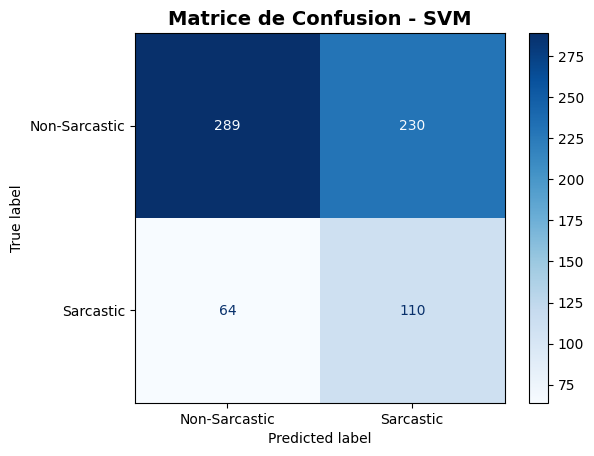


Matrice de confusion:
  [[TN: 289, FP: 230]
   [FN: 64, TP: 110]]

Rapport de classification:
               precision    recall  f1-score   support

Non-Sarcastic       0.82      0.56      0.66       519
    Sarcastic       0.32      0.63      0.43       174

     accuracy                           0.58       693
    macro avg       0.57      0.59      0.55       693
 weighted avg       0.69      0.58      0.60       693


Entraînement du modèle: Random Forest

Résultats pour Random Forest:
  Accuracy:  0.7244
  Precision: 0.3265
  Recall:    0.0920
  F1-Score:  0.1435
  AUC:       0.5998
  Temps d'entraînement: 15.67 secondes


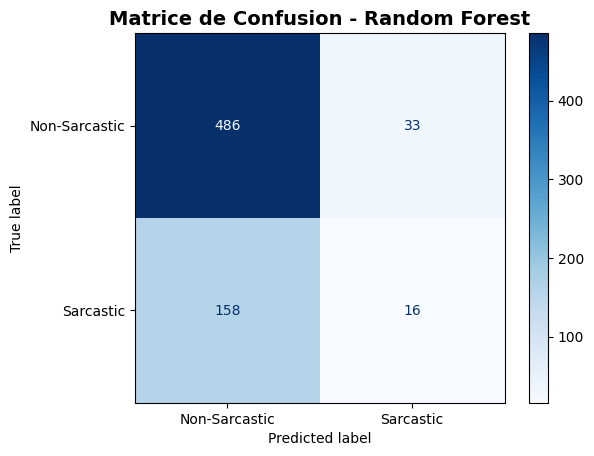


Matrice de confusion:
  [[TN: 486, FP: 33]
   [FN: 158, TP: 16]]

Rapport de classification:
               precision    recall  f1-score   support

Non-Sarcastic       0.75      0.94      0.84       519
    Sarcastic       0.33      0.09      0.14       174

     accuracy                           0.72       693
    macro avg       0.54      0.51      0.49       693
 weighted avg       0.65      0.72      0.66       693


Entraînement du modèle: Naive Bayes

Résultats pour Naive Bayes:
  Accuracy:  0.6234
  Precision: 0.3067
  Recall:    0.3966
  F1-Score:  0.3459
  AUC:       0.5701
  Temps d'entraînement: 0.03 secondes


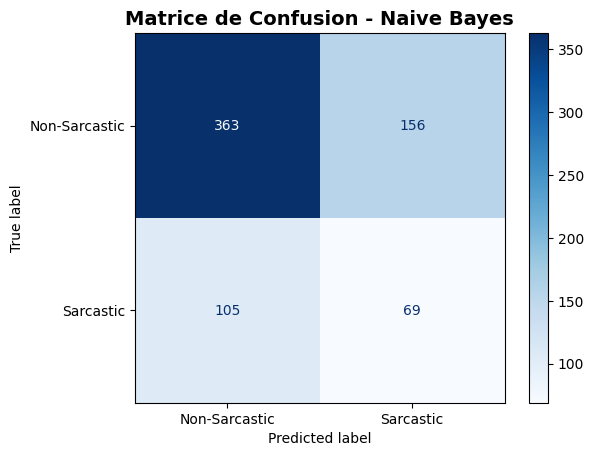


Matrice de confusion:
  [[TN: 363, FP: 156]
   [FN: 105, TP: 69]]

Rapport de classification:
               precision    recall  f1-score   support

Non-Sarcastic       0.78      0.70      0.74       519
    Sarcastic       0.31      0.40      0.35       174

     accuracy                           0.62       693
    macro avg       0.54      0.55      0.54       693
 weighted avg       0.66      0.62      0.64       693


Entraînement du modèle: KNN

Résultats pour KNN:
  Accuracy:  0.2814
  Precision: 0.2560
  Recall:    0.9770
  F1-Score:  0.4057
  AUC:       0.5845
  Temps d'entraînement: 0.00 secondes


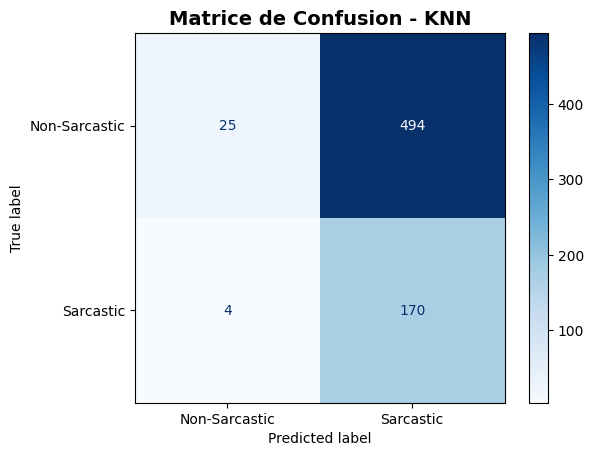


Matrice de confusion:
  [[TN: 25, FP: 494]
   [FN: 4, TP: 170]]

Rapport de classification:
               precision    recall  f1-score   support

Non-Sarcastic       0.86      0.05      0.09       519
    Sarcastic       0.26      0.98      0.41       174

     accuracy                           0.28       693
    macro avg       0.56      0.51      0.25       693
 weighted avg       0.71      0.28      0.17       693


COMPARAISON DES PERFORMANCES DES MODÈLES

Classement des modèles (par F1-Score):
             Modèle  Accuracy  Precision   Recall  F1-Score      AUC  Temps d'entraînement (s)
Logistic Regression  0.688312   0.407080 0.528736  0.460000 0.689511                  2.060589
                SVM  0.575758   0.323529 0.632184  0.428016 0.655183                 25.796428
                KNN  0.281385   0.256024 0.977011  0.405728 0.584479                  0.002254
        Naive Bayes  0.623377   0.306667 0.396552  0.345865 0.570095                  0.031124
      Random Fore

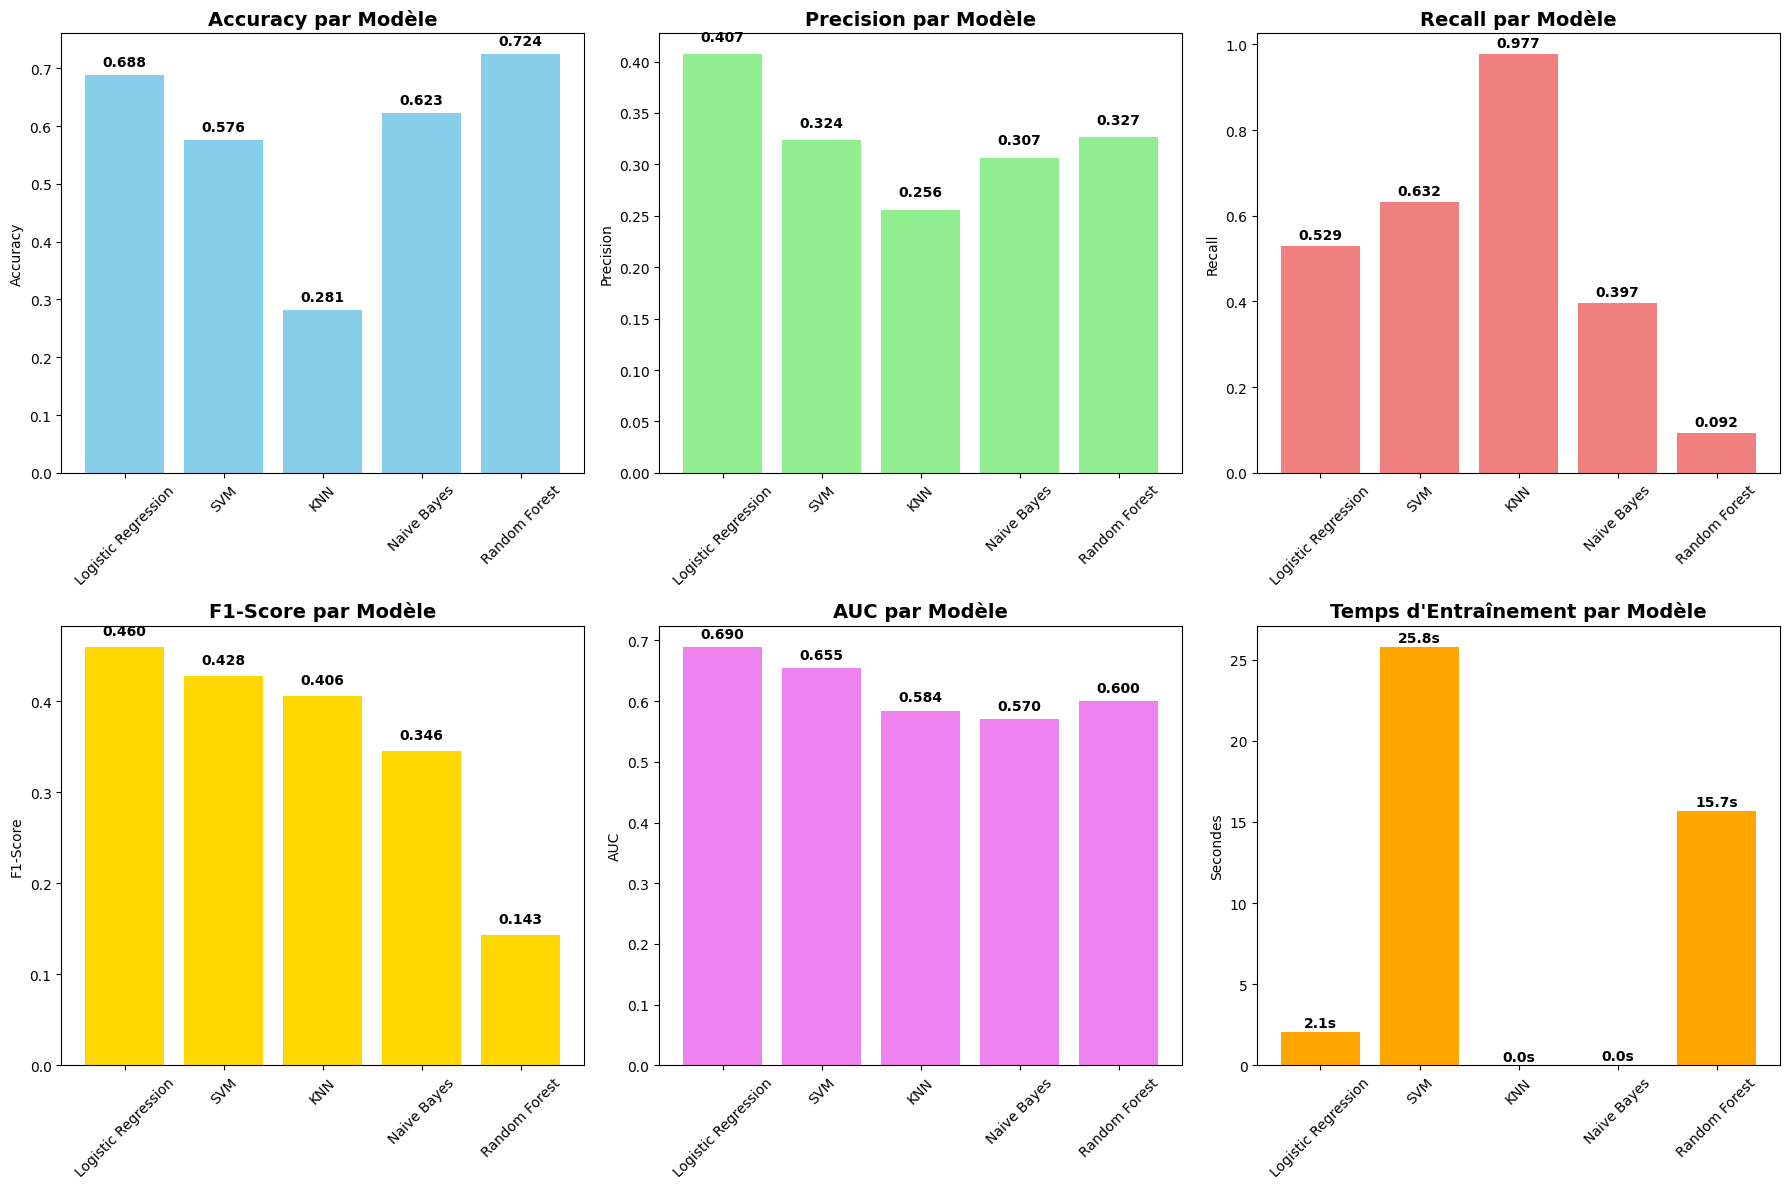


SAUVEGARDE DES MODÈLES
✓ Modèle Logistic Regression sauvegardé sous: modele_logistic_regression.pkl
✓ Modèle SVM sauvegardé sous: modele_svm.pkl
✓ Modèle Random Forest sauvegardé sous: modele_random_forest.pkl
✓ Modèle Naive Bayes sauvegardé sous: modele_naive_bayes.pkl
✓ Modèle KNN sauvegardé sous: modele_knn.pkl

ÉVALUATION SUR LE DATASET DE TEST
Nombre de tweets dans le dataset de test: 1400
Distribution des classes dans le test set:
sarcastic
0    1200
1     200
Name: count, dtype: int64
Non-sarcastic (0): 1200 (85.71%)
Sarcastic (1): 200 (14.29%)
Tweets après nettoyage: 1400

Extraction des embeddings RoBERTa pour le test set...


Extraction des embeddings: 100%|██████████| 88/88 [00:33<00:00,  2.67it/s]


Shape des embeddings de test: (1400, 768)

ÉVALUATION DES MODÈLES SUR LE TEST SET

Évaluation de Logistic Regression sur le test set

Résultats sur le test set pour Logistic Regression:
  Accuracy:  0.6586
  Precision: 0.2198
  Recall:    0.5450
  F1-Score:  0.3132
  AUC:       0.6409

Matrice de confusion:
  [[TN: 813, FP: 387]
   [FN: 91, TP: 109]]

Évaluation de SVM sur le test set

Résultats sur le test set pour SVM:
  Accuracy:  0.5143
  Precision: 0.1657
  Recall:    0.5950
  F1-Score:  0.2593
  AUC:       0.5811

Matrice de confusion:
  [[TN: 601, FP: 599]
   [FN: 81, TP: 119]]

Évaluation de Random Forest sur le test set

Résultats sur le test set pour Random Forest:
  Accuracy:  0.8436
  Precision: 0.3956
  Recall:    0.1800
  F1-Score:  0.2474
  AUC:       0.5966

Matrice de confusion:
  [[TN: 1145, FP: 55]
   [FN: 164, TP: 36]]

Évaluation de Naive Bayes sur le test set

Résultats sur le test set pour Naive Bayes:
  Accuracy:  0.6764
  Precision: 0.2092
  Recall:    0.4550
 

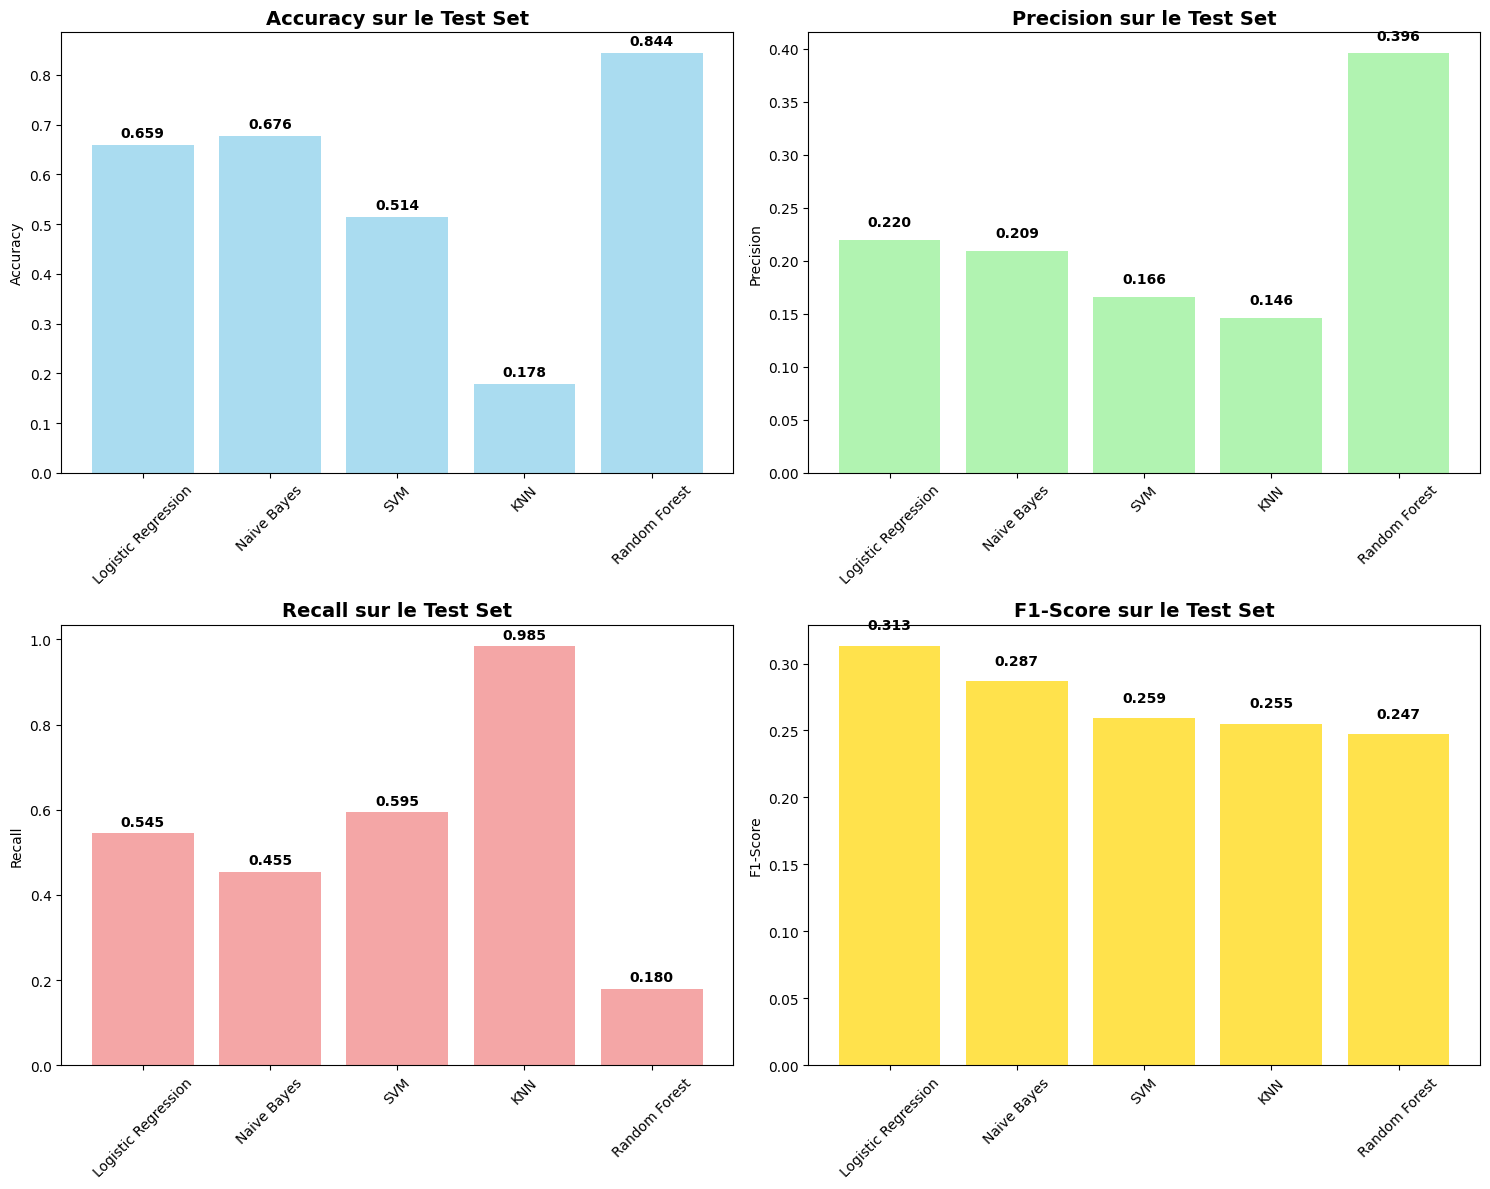


ANALYSE DU MEILLEUR MODÈLE
🌟 MEILLEUR MODÈLE: Logistic Regression
F1-Score sur le test set: 0.3132

Analyse des erreurs pour Logistic Regression:
False Positives (prédit sarcastique mais pas vrai): 387
False Negatives (prédit non-sarcastique mais vrai sarcastique): 91
✓ Prédictions sauvegardées dans 'predictions_finales_logistic_regression.csv'

RAPPORT FINAL

📊 PERFORMANCE GLOBALE SUR 1400 TWEETS DE TEST
Meilleur modèle: Logistic Regression
F1-Score: 0.3132
Accuracy: 0.6586
Precision: 0.2198
Recall: 0.5450

📈 CLASSEMENT COMPLET DES MODÈLES:
1. Logistic Regression: F1-Score = 0.3132
4. Naive Bayes: F1-Score = 0.2866
2. SVM: F1-Score = 0.2593
5. KNN: F1-Score = 0.2550
3. Random Forest: F1-Score = 0.2474

✅ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS AVEC SUCCÈS!


In [8]:
# ============================================================================
# ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES (INCLUANT NAIVE BAYES)
# ============================================================================

from sklearn.metrics import ConfusionMatrixDisplay


print("\n" + "="*80)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("="*80)

# Dictionnaire pour stocker les résultats
results = {}

# Définir tous les modèles incluant Naive Bayes
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print(f"\nNombre de modèles à entraîner: {len(models)}")
for name in models.keys():
    print(f" * {name}")

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Entraînement du modèle: {name}")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Entraînement du modèle
    model.fit(X_train_smote, y_train_smote)
    training_time = time.time() - start_time
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Stocker les résultats
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'training_time': training_time
    }
    
    # Affichage des résultats
    print(f"\nRésultats pour {name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if auc is not None:
        print(f"  AUC:       {auc:.4f}")
    print(f"  Temps d'entraînement: {training_time:.2f} secondes")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Non-Sarcastic', 'Sarcastic'], cmap=plt.cm.Blues)
    plt.title(f'Matrice de Confusion - {name}', fontweight='bold', fontsize=14)
    plt.show()

    print(f"\nMatrice de confusion:")
    print(f"  [[TN: {cm[0,0]}, FP: {cm[0,1]}]")
    print(f"   [FN: {cm[1,0]}, TP: {cm[1,1]}]]")
    
    # Rapport de classification détaillé
    print(f"\nRapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

# ============================================================================
# COMPARAISON DES PERFORMANCES DES MODÈLES
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON DES PERFORMANCES DES MODÈLES")
print("="*80)

# Créer un DataFrame pour comparer les résultats
comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'AUC': [results[name]['auc'] if results[name]['auc'] is not None else None for name in results.keys()],
    'Temps d\'entraînement (s)': [results[name]['training_time'] for name in results.keys()]
})

# Trier par F1-Score (métrique principale pour déséquilibre de classes)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\nClassement des modèles (par F1-Score):")
print(comparison_df.to_string(index=False))

# ============================================================================
# VISUALISATION DES PERFORMANCES
# ============================================================================

# Graphique comparatif des métriques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Accuracy
axes[0, 0].bar(comparison_df['Modèle'], comparison_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Accuracy par Modèle', fontweight='bold', fontsize=14)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision
axes[0, 1].bar(comparison_df['Modèle'], comparison_df['Precision'], color='lightgreen')
axes[0, 1].set_title('Precision par Modèle', fontweight='bold', fontsize=14)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Precision']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Recall
axes[0, 2].bar(comparison_df['Modèle'], comparison_df['Recall'], color='lightcoral')
axes[0, 2].set_title('Recall par Modèle', fontweight='bold', fontsize=14)
axes[0, 2].set_ylabel('Recall')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Recall']):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score
axes[1, 0].bar(comparison_df['Modèle'], comparison_df['F1-Score'], color='gold')
axes[1, 0].set_title('F1-Score par Modèle', fontweight='bold', fontsize=14)
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# AUC
axes[1, 1].bar(comparison_df['Modèle'], 
               [auc if auc is not None else 0 for auc in comparison_df['AUC']], 
               color='violet')
axes[1, 1].set_title('AUC par Modèle', fontweight='bold', fontsize=14)
axes[1, 1].set_ylabel('AUC')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['AUC']):
    if v is not None:
        axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Temps d'entraînement
axes[1, 2].bar(comparison_df['Modèle'], comparison_df['Temps d\'entraînement (s)'], color='orange')
axes[1, 2].set_title('Temps d\'Entraînement par Modèle', fontweight='bold', fontsize=14)
axes[1, 2].set_ylabel('Secondes')
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Temps d\'entraînement (s)']):
    axes[1, 2].text(i, v + 0.1, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# SAUVEGARDE DES MODÈLES
# ============================================================================

print("\n" + "="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

import joblib

for name, result in results.items():
    filename = f'modele_{name.lower().replace(" ", "_")}.pkl'
    joblib.dump(result['model'], filename)
    print(f"✓ Modèle {name} sauvegardé sous: {filename}")

# ============================================================================
# ÉVALUATION SUR LE DATASET DE TEST
# ============================================================================

print("\n" + "="*80)
print("ÉVALUATION SUR LE DATASET DE TEST")
print("="*80)

# Charger le dataset de test
test_df = pd.read_csv('task_A_En_test.csv')

print(f"Nombre de tweets dans le dataset de test: {len(test_df)}")
print(f"Distribution des classes dans le test set:")
print(test_df['sarcastic'].value_counts())
print(f"Non-sarcastic (0): {(test_df['sarcastic'] == 0).sum()} ({(test_df['sarcastic'] == 0).sum() / len(test_df) * 100:.2f}%)")
print(f"Sarcastic (1): {(test_df['sarcastic'] == 1).sum()} ({(test_df['sarcastic'] == 1).sum() / len(test_df) * 100:.2f}%)")

# Appliquer le même prétraitement
test_df['text_clean_bert'] = test_df['tweet'].apply(preprocess_text_for_bert)
test_df_clean = test_df[test_df['text_clean_bert'].str.len() > 0].copy()

print(f"Tweets après nettoyage: {len(test_df_clean)}")

# Extraire les embeddings pour le test set
print("\nExtraction des embeddings RoBERTa pour le test set...")
X_test_final = get_roberta_embeddings(test_df_clean['text_clean_bert'].tolist())
y_test_final = test_df_clean['sarcastic'].values

print(f"Shape des embeddings de test: {X_test_final.shape}")

# ============================================================================
# ÉVALUATION DES MODÈLES SUR LE TEST SET
# ============================================================================

print("\n" + "="*80)
print("ÉVALUATION DES MODÈLES SUR LE TEST SET")
print("="*80)

test_results = {}

for name, result in results.items():
    print(f"\n{'='*50}")
    print(f"Évaluation de {name} sur le test set")
    print(f"{'='*50}")
    
    model = result['model']
    
    # Prédictions sur le test set
    y_pred_test = model.predict(X_test_final)
    y_pred_proba_test = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calcul des métriques
    test_accuracy = accuracy_score(y_test_final, y_pred_test)
    test_precision = precision_score(y_test_final, y_pred_test)
    test_recall = recall_score(y_test_final, y_pred_test)
    test_f1 = f1_score(y_test_final, y_pred_test)
    test_auc = roc_auc_score(y_test_final, y_pred_proba_test) if y_pred_proba_test is not None else None
    
    # Stocker les résultats
    test_results[name] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'auc': test_auc
    }
    
    # Affichage des résultats
    print(f"\nRésultats sur le test set pour {name}:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    if test_auc is not None:
        print(f"  AUC:       {test_auc:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test_final, y_pred_test)
    print(f"\nMatrice de confusion:")
    print(f"  [[TN: {cm[0,0]}, FP: {cm[0,1]}]")
    print(f"   [FN: {cm[1,0]}, TP: {cm[1,1]}]]")

# ============================================================================
# COMPARAISON FINALE SUR LE TEST SET
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON FINALE SUR LE TEST SET")
print("="*80)

# Créer un DataFrame pour comparer les résultats sur le test set
final_comparison_df = pd.DataFrame({
    'Modèle': list(test_results.keys()),
    'Accuracy': [test_results[name]['accuracy'] for name in test_results.keys()],
    'Precision': [test_results[name]['precision'] for name in test_results.keys()],
    'Recall': [test_results[name]['recall'] for name in test_results.keys()],
    'F1-Score': [test_results[name]['f1_score'] for name in test_results.keys()],
    'AUC': [test_results[name]['auc'] if test_results[name]['auc'] is not None else None for name in test_results.keys()]
})

# Trier par F1-Score
final_comparison_df = final_comparison_df.sort_values('F1-Score', ascending=False)

print("\nClassement final des modèles sur le test set (par F1-Score):")
print(final_comparison_df.to_string(index=False))

# ============================================================================
# VISUALISATION DES RÉSULTATS FINAUX
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy sur test set
axes[0, 0].bar(final_comparison_df['Modèle'], final_comparison_df['Accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Accuracy sur le Test Set', fontweight='bold', fontsize=14)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(final_comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision sur test set
axes[0, 1].bar(final_comparison_df['Modèle'], final_comparison_df['Precision'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Precision sur le Test Set', fontweight='bold', fontsize=14)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(final_comparison_df['Precision']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Recall sur test set
axes[1, 0].bar(final_comparison_df['Modèle'], final_comparison_df['Recall'], color='lightcoral', alpha=0.7)
axes[1, 0].set_title('Recall sur le Test Set', fontweight='bold', fontsize=14)
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(final_comparison_df['Recall']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score sur test set
axes[1, 1].bar(final_comparison_df['Modèle'], final_comparison_df['F1-Score'], color='gold', alpha=0.7)
axes[1, 1].set_title('F1-Score sur le Test Set', fontweight='bold', fontsize=14)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(final_comparison_df['F1-Score']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# ANALYSE DU MEILLEUR MODÈLE
# ============================================================================

print("\n" + "="*80)
print("ANALYSE DU MEILLEUR MODÈLE")
print("="*80)

# Identifier le meilleur modèle
best_model_name = final_comparison_df.iloc[0]['Modèle']
best_model = results[best_model_name]['model']

print(f"🌟 MEILLEUR MODÈLE: {best_model_name}")
print(f"F1-Score sur le test set: {final_comparison_df.iloc[0]['F1-Score']:.4f}")

# Analyse détaillée du meilleur modèle
y_best_pred = best_model.predict(X_test_final)
y_best_pred_proba = best_model.predict_proba(X_test_final)[:, 1] if hasattr(best_model, "predict_proba") else None

# Ajouter les prédictions au dataframe de test
test_df_clean['prediction'] = y_best_pred
test_df_clean['prediction_proba'] = y_best_pred_proba if y_best_pred_proba is not None else np.nan

# False positives et false negatives
false_positives = test_df_clean[(test_df_clean['sarcastic'] == 0) & (test_df_clean['prediction'] == 1)]
false_negatives = test_df_clean[(test_df_clean['sarcastic'] == 1) & (test_df_clean['prediction'] == 0)]

print(f"\nAnalyse des erreurs pour {best_model_name}:")
print(f"False Positives (prédit sarcastique mais pas vrai): {len(false_positives)}")
print(f"False Negatives (prédit non-sarcastique mais vrai sarcastique): {len(false_negatives)}")

# Sauvegarder les prédictions du meilleur modèle
best_model_predictions = test_df_clean[['tweet', 'sarcastic', 'prediction', 'prediction_proba']].copy()
best_model_predictions.to_csv(f'predictions_finales_{best_model_name.lower().replace(" ", "_")}.csv', index=False)
print(f"✓ Prédictions sauvegardées dans 'predictions_finales_{best_model_name.lower().replace(' ', '_')}.csv'")

# ============================================================================
# RAPPORT FINAL
# ============================================================================

print("\n" + "="*80)
print("RAPPORT FINAL")
print("="*80)

print(f"\n📊 PERFORMANCE GLOBALE SUR {len(test_df_clean)} TWEETS DE TEST")
print(f"Meilleur modèle: {best_model_name}")
print(f"F1-Score: {final_comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"Accuracy: {final_comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"Precision: {final_comparison_df.iloc[0]['Precision']:.4f}")
print(f"Recall: {final_comparison_df.iloc[0]['Recall']:.4f}")

print(f"\n📈 CLASSEMENT COMPLET DES MODÈLES:")
for i, row in final_comparison_df.iterrows():
    print(f"{i+1}. {row['Modèle']}: F1-Score = {row['F1-Score']:.4f}")

print(f"\n✅ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS AVEC SUCCÈS!")
print("="*80)